In [1]:
##### CSM010 Applied Machine Learning 
##### Nicholas Catani
##### ID: 240428576

In [4]:
!python3 -m pip install numpy matplotlib seaborn scipy scikit-learn xgboost tensorflow

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 292 kB 26.8 MB/s            
     |████████████████████████████████| 22.2 MB 61.4 MB/s            ta 0:00:01
     |████████████████████████████████| 173.6 MB 6.4 kB/s              
     |████████████████████████████████| 458.3 MB 5.7 kB/s              
     |████████████████████████████████| 9.5 MB 72.4 MB/s            
     |████████████████████████████████| 309 kB 83.3 MB/s            
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 5.6 MB 68.3 MB/s            
     |████████████████████████████████| 462 kB 102.8 MB/s            
     |████████████████████████████████| 1.3 MB 41.2 MB/s            
     |████████████████████████████████| 132 kB 86.7 MB/s            
     |████████████████████████████████| 4.6 MB 58.8 MB/s            
     |████████████████████████████████| 65 kB 1.6 MB/s         

In [5]:
##### Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from IPython.display import display

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
##### STEP 0: DATA PIPELINING
##### 
##### Raw data (pokemon & combats) into DataMart (similar one-to-one Training.csv)

pokemon = pd.read_csv("./Pokemon.csv")
combats = pd.read_csv("./Combats.csv")

# Prepare data
pokemon = pokemon.rename(columns={'#': 'id'})
pokemon = pokemon.drop(columns=['sprites'])  # Drop unneeded URL

# Merge Pokémon stats
first = pokemon.add_suffix('_first')
first = first.rename(columns={'id_first': 'First_pokemon'})
merged = combats.merge(first, on='First_pokemon', how='left')

second = pokemon.add_suffix('_second')
second = second.rename(columns={'id_second': 'Second_pokemon'})
merged = merged.merge(second, on='Second_pokemon', how='left')

# Create stat-difference features
stat_features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed',
                 'height', 'weight', 'base_experience']
for feat in stat_features:
    merged[f"{feat}_diff"] = merged[f"{feat}_first"] - merged[f"{feat}_second"]

# Encode types
for col in ['Type 1_first', 'Type 2_first', 'Type 1_second', 'Type 2_second']:
    merged[col] = LabelEncoder().fit_transform(merged[col])

# Convert Legendary to int
merged['Legendary_first'] = merged['Legendary_first'].astype(int)
merged['Legendary_second'] = merged['Legendary_second'].astype(int)

# Create binary target: 1 if First Pokémon wins, else 0
merged['first_wins'] = (merged['Winner'] == merged['First_pokemon']).astype(int)

DataMart = merged
DataMart

,First_pokemon,Second_pokemon,Winner,Name_first,Type 1_first,Type 2_first,HP_first,Attack_first,Defense_first,Sp. Atk_first,...,HP_diff,Attack_diff,Defense_diff,Sp. Atk_diff,Sp. Def_diff,Speed_diff,height_diff,weight_diff,base_experience_diff,first_wins
0,266,298,298,Larvitar,15,10,50,64,50,45,...,-20,-6,10,-15,10,-19,-4,440,-59,0
1,702,701,701,Virizion,9,5,91,90,72,90,...,0,-39,-18,18,39,0,1,-600,0,0
2,191,668,668,Togetic,4,7,55,40,85,80,...,-20,-35,10,-45,10,0,-4,-313,-28,0
3,237,683,683,Slugma,6,12,40,40,40,70,...,-37,-80,-50,10,-50,-28,-9,-1040,-120,0
4,151,231,151,Omastar,15,17,70,60,125,115,...,50,50,-105,105,-160,50,4,145,-4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38049,657,681,681,Joltik,0,3,50,47,50,57,...,5,-38,0,2,0,0,-8,-194,-6,0
38050,707,126,707,Reshiram,2,6,100,120,100,150,...,70,80,30,80,95,30,28,3220,247,1
38051,589,664,589,Drilbur,10,12,60,85,40,30,...,25,30,0,-15,5,8,1,82,11,1
38052,303,368,368,Pelipper,17,7,60,50,100,85,...,-13,-65,40,25,10,-25,-1,-123,-6,0


In [8]:
### STEP 1: LOAD PRE-PROCESSED DATA

df = pd.read_csv("./Training.csv")
df

,First_pokemon_id,Second_pokemon_id,Winner,Name_first,Type 1_first,Type 2_first,HP_first,Attack_first,Defense_first,Sp. Atk_first,...,Attack_second,Defense_second,Sp. Atk_second,Sp. Def_second,Speed_second,Generation_second,Legendary_second,height_second,weight_second,base_experience_second
0,266,298,298,Larvitar,Rock,Ground,50,64,50,45,...,70,40,60,40,60,3,False,10,280,119
1,702,701,701,Virizion,Grass,Fighting,91,90,72,90,...,129,90,72,90,108,5,True,19,2600,261
2,191,668,668,Togetic,Fairy,Flying,55,40,85,80,...,75,75,125,95,40,5,False,10,345,170
3,237,683,683,Slugma,Fire,Normal,40,40,40,70,...,120,90,60,90,48,5,False,16,1390,170
4,151,231,151,Omastar,Rock,Water,70,60,125,115,...,10,230,10,230,5,2,False,6,205,177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38049,657,681,681,Joltik,Bug,Electric,50,47,50,57,...,85,50,55,50,65,5,False,9,200,70
38050,707,126,707,Reshiram,Dragon,Fire,100,120,100,150,...,40,70,70,25,60,1,False,4,80,59
38051,589,664,589,Drilbur,Ground,Normal,60,85,40,30,...,55,40,45,40,60,5,False,2,3,55
38052,303,368,368,Pelipper,Water,Flying,60,50,100,85,...,115,60,60,60,90,3,False,13,403,160


In [9]:
### STEP 2: EXPLORATORY DATA ANALYSIS
df['first_wins'] = (df['Winner'] == df['First_pokemon_id']).astype(int)

In [10]:
## Missing values
df.isnull().sum()

First_pokemon_id          0
Second_pokemon_id         0
Winner                    0
Name_first                0
Type 1_first              0
Type 2_first              0
HP_first                  0
Attack_first              0
Defense_first             0
Sp. Atk_first             0
Sp. Def_first             0
Speed_first               0
Generation_first          0
Legendary_first           0
height_first              0
weight_first              0
base_experience_first     0
Name_second               0
Type 1_second             0
Type 2_second             0
HP_second                 0
Attack_second             0
Defense_second            0
Sp. Atk_second            0
Sp. Def_second            0
Speed_second              0
Generation_second         0
Legendary_second          0
height_second             0
weight_second             0
base_experience_second    0
first_wins                0
dtype: int64

In [32]:
## Data types
df.dtypes

First_pokemon_id           int64
Second_pokemon_id          int64
Winner                     int64
Name_first                object
Type 1_first               int64
Type 2_first               int64
HP_first                   int64
Attack_first               int64
Defense_first              int64
Sp. Atk_first              int64
Sp. Def_first              int64
Speed_first                int64
Generation_first           int64
Legendary_first            int64
height_first               int64
weight_first               int64
base_experience_first      int64
Name_second               object
Type 1_second              int64
Type 2_second              int64
HP_second                  int64
Attack_second              int64
Defense_second             int64
Sp. Atk_second             int64
Sp. Def_second             int64
Speed_second               int64
Generation_second          int64
Legendary_second           int64
height_second              int64
weight_second              int64
base_exper

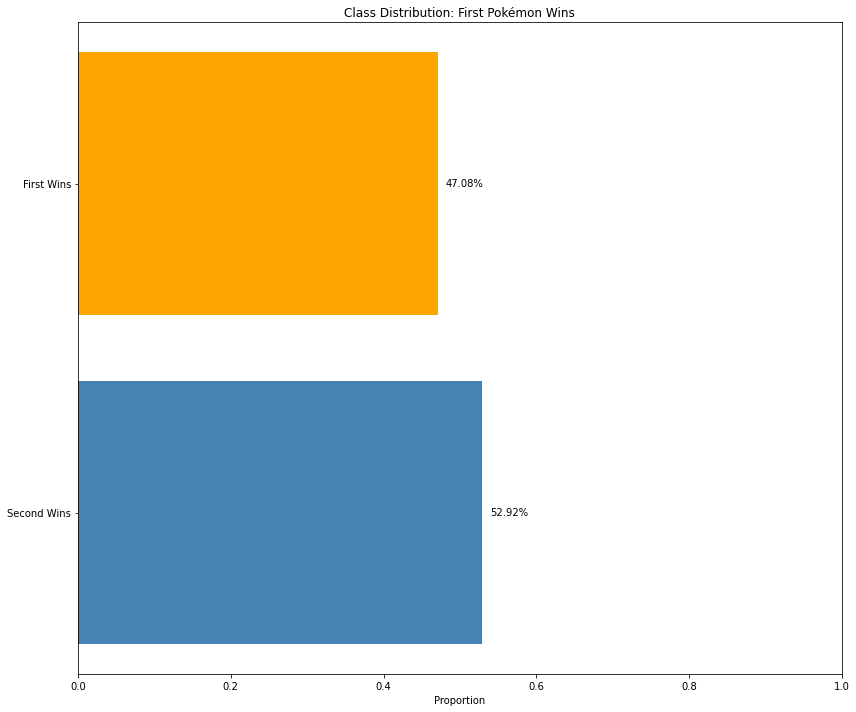

In [35]:
## 'Target' Class balance

# Class distribution (normalized)
class_counts = df['first_wins'].value_counts(normalize=True)

# Labels mapping
labels = ['Second Wins', 'First Wins'] if 0 in class_counts.index else ['First Wins', 'Second Wins']

# Horizontal bar plot
plt.figure(figsize=(12, 10))
plt.barh(labels, class_counts.values, color=['steelblue', 'orange'])
plt.title('Class Distribution: First Pokémon Wins')
plt.xlabel('Proportion')
plt.xlim(0, 1)
for i, v in enumerate(class_counts.values):
    plt.text(v + 0.01, i, f'{v:.2%}', va='center')
    
plt.tight_layout()
plt.show()

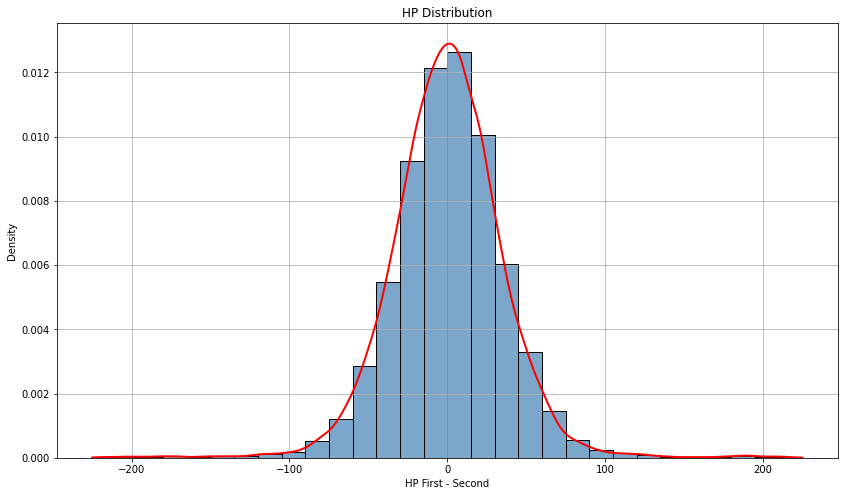

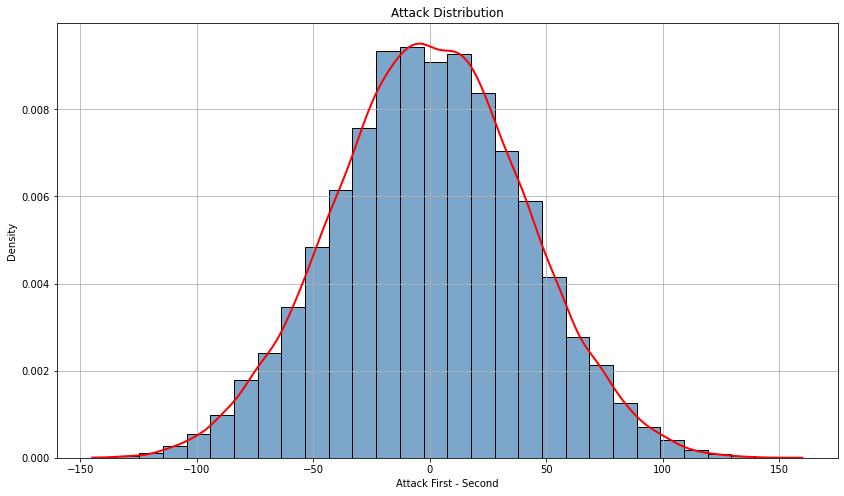

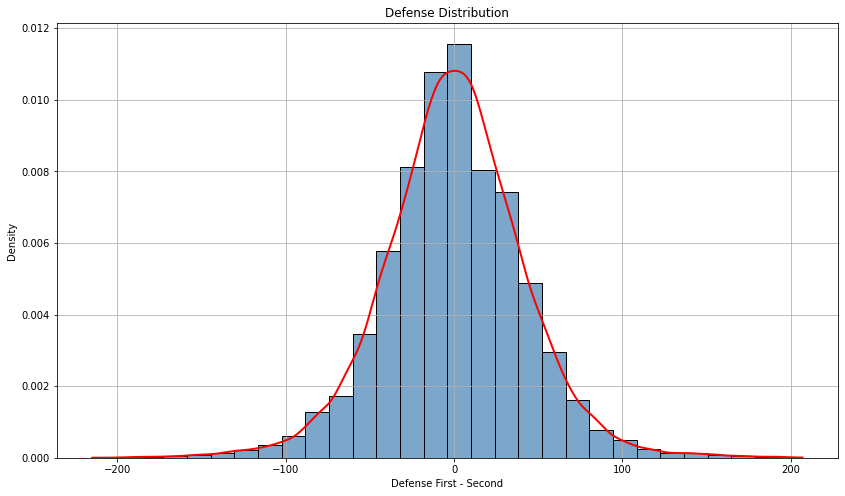

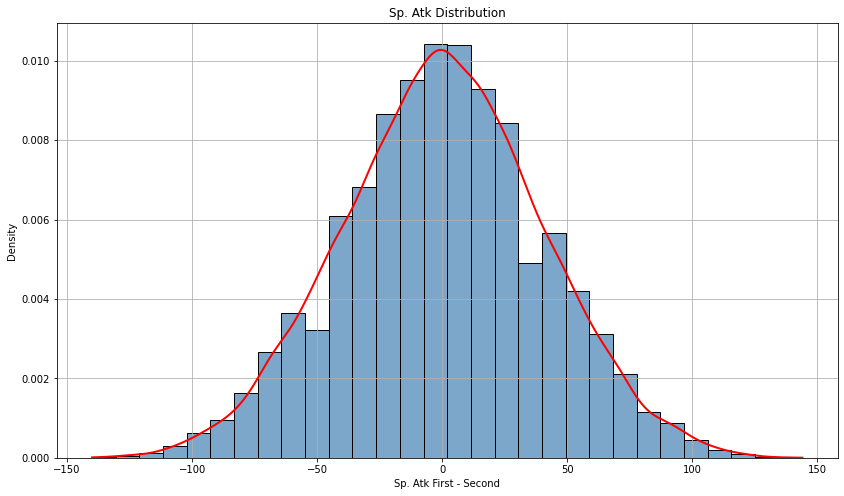

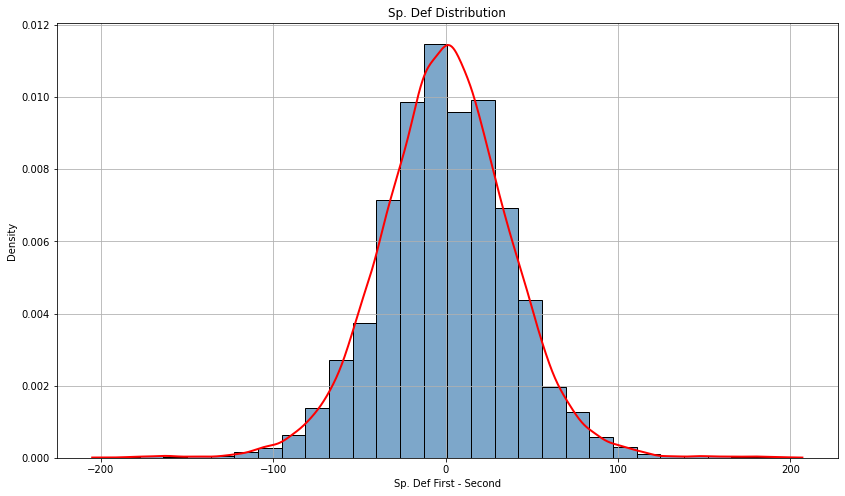

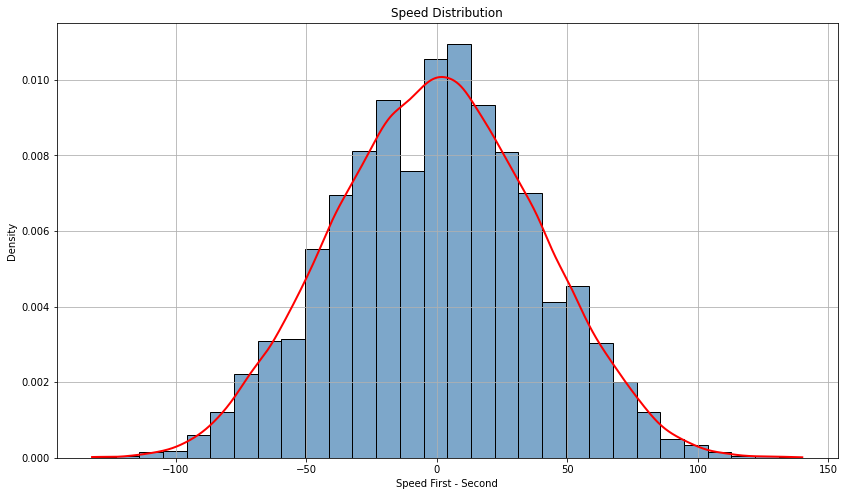

In [25]:
## Distribution
stat_cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']

for stat in stat_cols:
    # Compute stat difference
    diff_col = df[f'{stat}_first'] - df[f'{stat}_second']
    diff_col = diff_col.dropna()

    # KDE values
    kde = gaussian_kde(diff_col)
    x_vals = np.linspace(diff_col.min(), diff_col.max(), 1000)
    kde_vals = kde(x_vals)

    # Plot histogram
    plt.figure(figsize=(14, 8))
    sns.histplot(diff_col, bins=30, stat='density', edgecolor='black', alpha=0.7, color='steelblue')

    # Add red KDE line
    plt.plot(x_vals, kde_vals, color='red', linewidth=2)

    # Labels
    plt.title(f'{stat} Distribution')
    plt.xlabel(f'{stat} First - Second')
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()

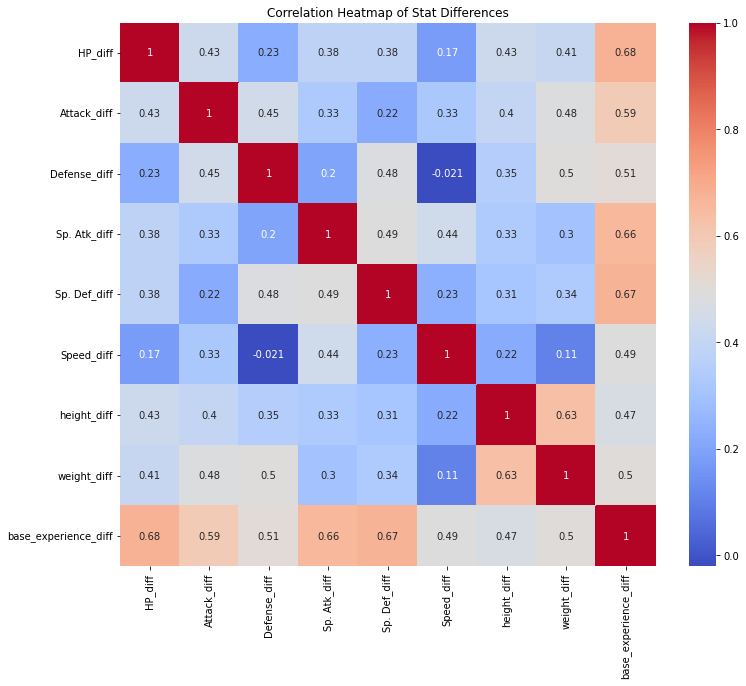

In [24]:
## Correlation Heatmap
stat_features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed',
                'height', 'weight', 'base_experience']

for feature in stat_features:
    df[f'{feature}_diff'] = df[f'{feature}_first'] - df[f'{feature}_second']

plt.figure(figsize=(12, 10))
sns.heatmap(df[[f'{f}_diff' for f in stat_features]].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Stat Differences')
plt.show()

In [14]:
### STEP 3: FEATURE ENGINEERING

df['Type 1_first'] = LabelEncoder().fit_transform(df['Type 1_first'])
df['Type 2_first'] = LabelEncoder().fit_transform(df['Type 2_first'])
df['Type 1_second'] = LabelEncoder().fit_transform(df['Type 1_second'])
df['Type 2_second'] = LabelEncoder().fit_transform(df['Type 2_second'])
df['Legendary_first'] = df['Legendary_first'].astype(int)
df['Legendary_second'] = df['Legendary_second'].astype(int)
df

,First_pokemon_id,Second_pokemon_id,Winner,Name_first,Type 1_first,Type 2_first,HP_first,Attack_first,Defense_first,Sp. Atk_first,...,first_wins,HP_diff,Attack_diff,Defense_diff,Sp. Atk_diff,Sp. Def_diff,Speed_diff,height_diff,weight_diff,base_experience_diff
0,266,298,298,Larvitar,15,10,50,64,50,45,...,0,-20,-6,10,-15,10,-19,-4,440,-59
1,702,701,701,Virizion,9,5,91,90,72,90,...,0,0,-39,-18,18,39,0,1,-600,0
2,191,668,668,Togetic,4,7,55,40,85,80,...,0,-20,-35,10,-45,10,0,-4,-313,-28
3,237,683,683,Slugma,6,12,40,40,40,70,...,0,-37,-80,-50,10,-50,-28,-9,-1040,-120
4,151,231,151,Omastar,15,17,70,60,125,115,...,1,50,50,-105,105,-160,50,4,145,-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38049,657,681,681,Joltik,0,3,50,47,50,57,...,0,5,-38,0,2,0,0,-8,-194,-6
38050,707,126,707,Reshiram,2,6,100,120,100,150,...,1,70,80,30,80,95,30,28,3220,247
38051,589,664,589,Drilbur,10,12,60,85,40,30,...,1,25,30,0,-15,5,8,1,82,11
38052,303,368,368,Pelipper,17,7,60,50,100,85,...,0,-13,-65,40,25,10,-25,-1,-123,-6


In [15]:
## Selection
features = [col for col in df.columns if '_diff' in col] + [
    'Legendary_first', 'Legendary_second',
    'Type 1_first', 'Type 2_first', 'Type 1_second', 'Type 2_second',
    'Generation_first', 'Generation_second',
]

X = df[features]
y = df['first_wins']

X_scaled = StandardScaler().fit_transform(X)
X_scaled

array([[-5.59194671e-01, -1.46422300e-01,  2.34531005e-01, ...,
        -2.72722395e+00, -7.86986483e-01, -1.91560160e-01],
       [-3.16493003e-04, -9.57957893e-01, -4.34354435e-01, ...,
        -1.57897948e+00,  1.03352274e+00,  1.02004631e+00],
       [-5.59194671e-01, -8.59589942e-01,  2.34531005e-01, ...,
         4.30448351e-01, -7.86986483e-01,  1.02004631e+00],
       ...,
       [ 6.98281230e-01,  7.38889256e-01, -4.35665197e-03, ...,
         4.30448351e-01,  1.03352274e+00,  1.02004631e+00],
       [-3.63587309e-01, -1.59734957e+00,  9.51193976e-01, ...,
         4.30448351e-01, -1.80150074e-01, -1.91560160e-01],
       [ 4.18842141e-01, -1.21830312e-01, -4.82131966e-01, ...,
         1.57869282e+00, -1.39382289e+00, -1.40316663e+00]])

In [16]:
### STEP 4: MODELING & EVALUATION

## Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [28]:
## Loop function for sklearn models
def evaluate_sklearn_model(model, X, y, name, cv):
    all_y_true = []
    all_y_pred = []
    all_y_prob = []

    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1]

        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)
        all_y_prob.extend(y_prob)
        
    print(f"\n===📋 {name} CLASSIFICATION REPORT ===")
    print(classification_report(all_y_true, all_y_pred))
    
    print(f"\n===🧮 {name} CONFUSION MATRIX ===")
    
    labels = ["Second Wins", "First Wins"]
    cm = confusion_matrix(all_y_true, all_y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
               xticklabels=labels, yticklabels=labels)
    plt.title(f'{name} Confusion Matrix (All Folds)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    auc_score = roc_auc_score(all_y_true, all_y_prob)
    print(f"\n===🎯 {name} ROC AUC Score: {auc_score:.4f} ===")
    
    fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
    plt.figure(figsize=(12, 10))
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})", linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()


===📋 Random Forest CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     20138
           1       0.94      0.96      0.95     17916

    accuracy                           0.95     38054
   macro avg       0.95      0.95      0.95     38054
weighted avg       0.95      0.95      0.95     38054


===🧮 Random Forest CONFUSION MATRIX ===


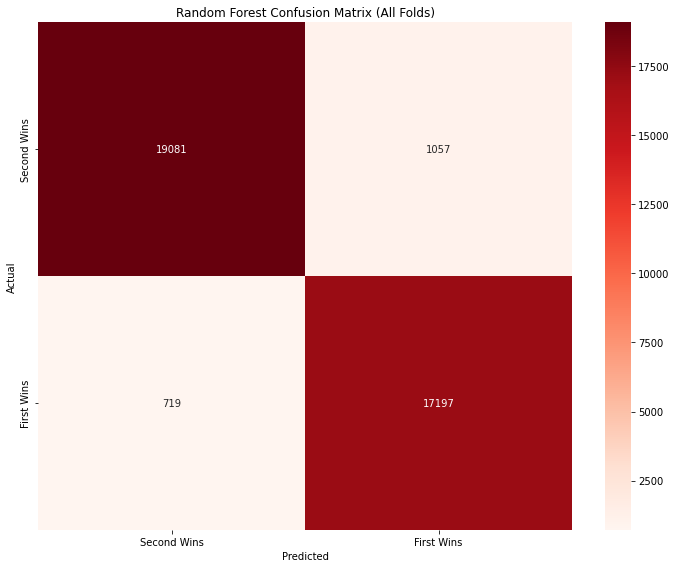


===🎯 Random Forest ROC AUC Score: 0.9885 ===


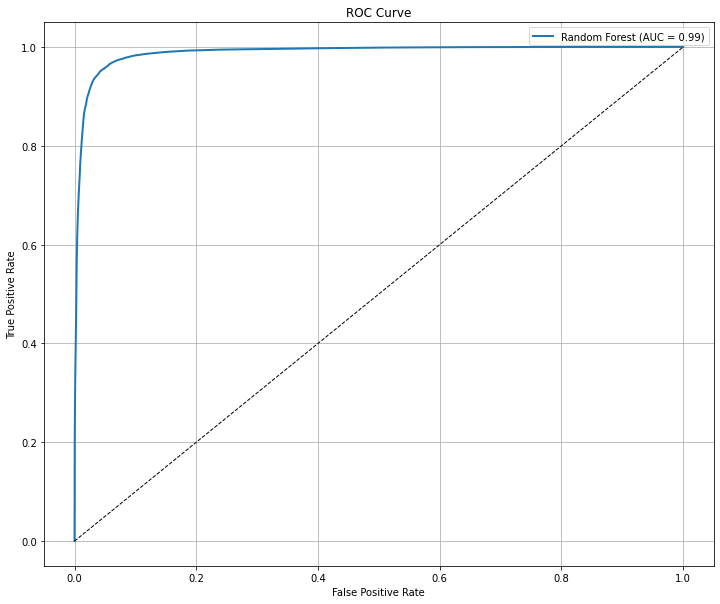

In [29]:
########## Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_sklearn_model(rf, X_scaled, y, "Random Forest", cv)


===📋 XGBoost CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     20138
           1       0.96      0.97      0.96     17916

    accuracy                           0.97     38054
   macro avg       0.97      0.97      0.97     38054
weighted avg       0.97      0.97      0.97     38054


===🧮 XGBoost CONFUSION MATRIX ===


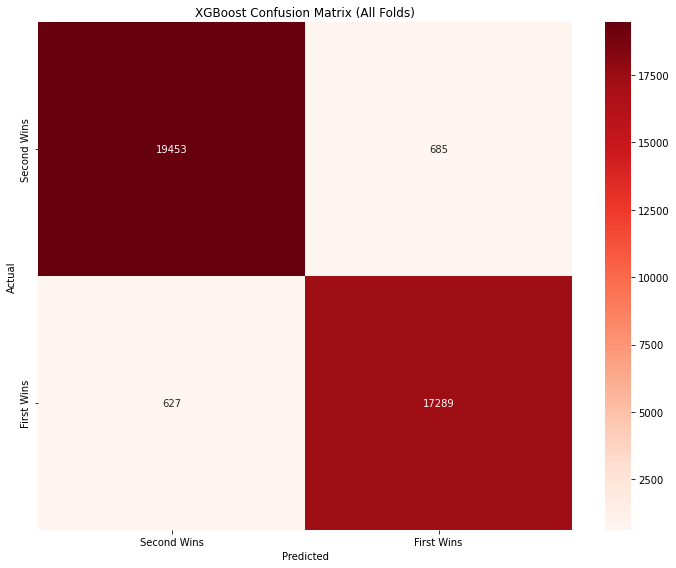


===🎯 XGBoost ROC AUC Score: 0.9942 ===


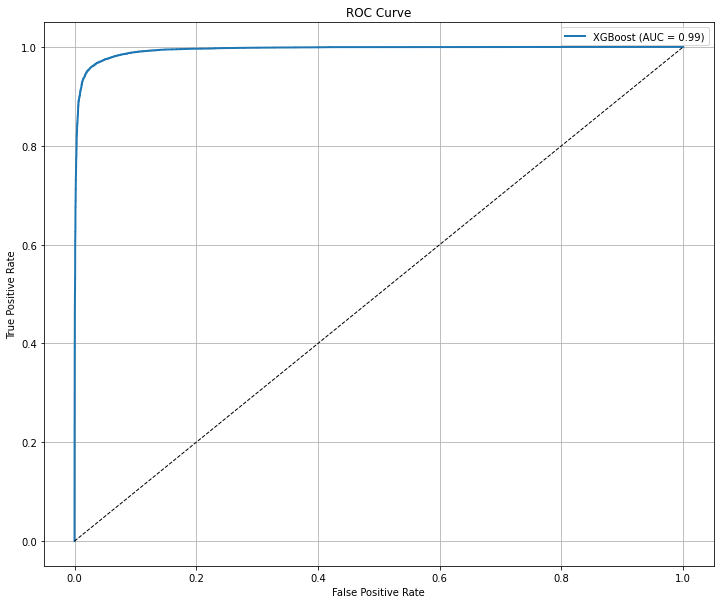

In [30]:
########## XGBoost
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
evaluate_sklearn_model(xgb, X_scaled, y, "XGBoost", cv)

In [18]:
## Loop function for DNN
def evaluate_dnn(X, y, name, cv):
    all_y_true = []
    all_y_pred = []
    all_y_prob = []
    plotted = False
    
    for train_idx, val_idx in cv.split(X, y):
        X_train_cv, X_val_cv = X[train_idx], X[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
        
        # Model
        dnn = Sequential([
            Dense(256, activation='relu', input_shape=(X_train_cv.shape[1],)),
            BatchNormalization(),
            Dropout(0.3),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dropout(0.2),
            Dense(64, activation='relu'),
            BatchNormalization(),
            Dropout(0.1),
            Dense(1, activation='sigmoid')
        ])
        
        dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        # Early stopping
        es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        
        history = dnn.fit(
            X_train_cv, y_train_cv, 
            validation_split=0.1, 
            epochs=100, 
            batch_size=32, 
            callbacks=[es], 
            verbose=0
        )
        
        # Predictions
        y_prob_cv = dnn.predict(X_val_cv).flatten()
        y_pred_cv = (y_prob_cv > 0.5).astype(int)
        
        if not plotted:
            ## Plot learning curves
            plt.figure(figsize=(12, 5))
            
            plt.subplot(1, 2, 1)
            plt.plot(history.history['loss'], label='Training Loss')
            plt.plot(history.history['val_loss'], label='Validation Loss')
            plt.title('Training and Test Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            
            plt.subplot(1, 2, 2)
            plt.plot(history.history['accuracy'], label='Training Accuracy')
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
            plt.title('Training and Test Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            
            plt.tight_layout()
            plt.show()
            
            plotted = True
        
        all_y_true.extend(y_val_cv)
        all_y_pred.extend(y_pred_cv)
        all_y_prob.extend(y_prob_cv)
        
    print(f"\n===📋 {name} CLASSIFICATION REPORT ===")
    print(classification_report(all_y_true, all_y_pred))
    
    print(f"\n===🧮 {name} CONFUSION MATRIX ===")
    
    labels = ["Second Wins", "First Wins"]
    cm = confusion_matrix(all_y_true, all_y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
               xticklabels=labels, yticklabels=labels)
    plt.title(f'{name} Confusion Matrix (All Folds)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    auc_score = roc_auc_score(all_y_true, all_y_prob)
    print(f"\n===🎯 {name} ROC AUC Score: {auc_score:.4f} ===")
    
    fpr, tpr, _ = roc_curve(all_y_true, all_y_prob)
    plt.figure(figsize=(12, 10))
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})", linewidth=2, color='purple')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

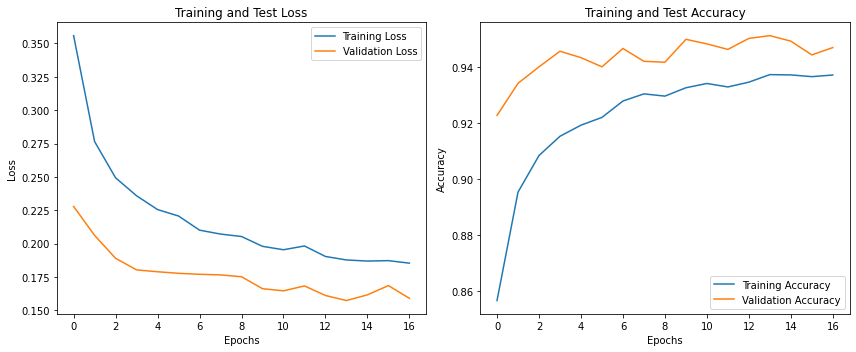


===📋 DNN CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     20138
           1       0.93      0.95      0.94     17916

    accuracy                           0.94     38054
   macro avg       0.94      0.94      0.94     38054
weighted avg       0.94      0.94      0.94     38054


===🧮 DNN CONFUSION MATRIX ===


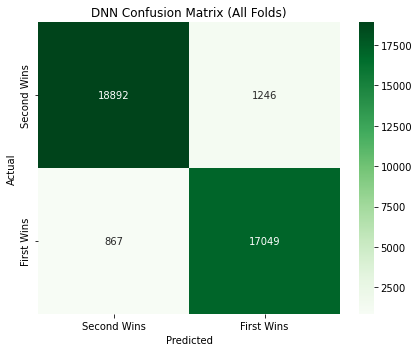


===🎯 DNN ROC AUC Score: 0.9804 ===


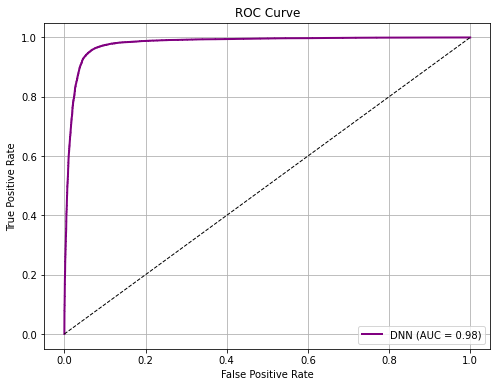

In [19]:
########## Deep Neural Network
evaluate_dnn(X_scaled, y, 'DNN', cv)